#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
#Импортируем необходимые параметры
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Откроем файл с временем и датами
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
#Изучим информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
#Проверка, что индекс монотонный
df.index.is_monotonic

True

In [5]:
#Сделаем датафрейм с ресемплингом
df_resample = df.resample("1H").sum()

### Вывод

С данными всё в порядке, пропусков не обнаружено, индекс монотонный.

## Анализ

In [6]:
#Разложеним временной ряд на тренд, сезонность и остаток
decomposed = seasonal_decompose(df_resample)

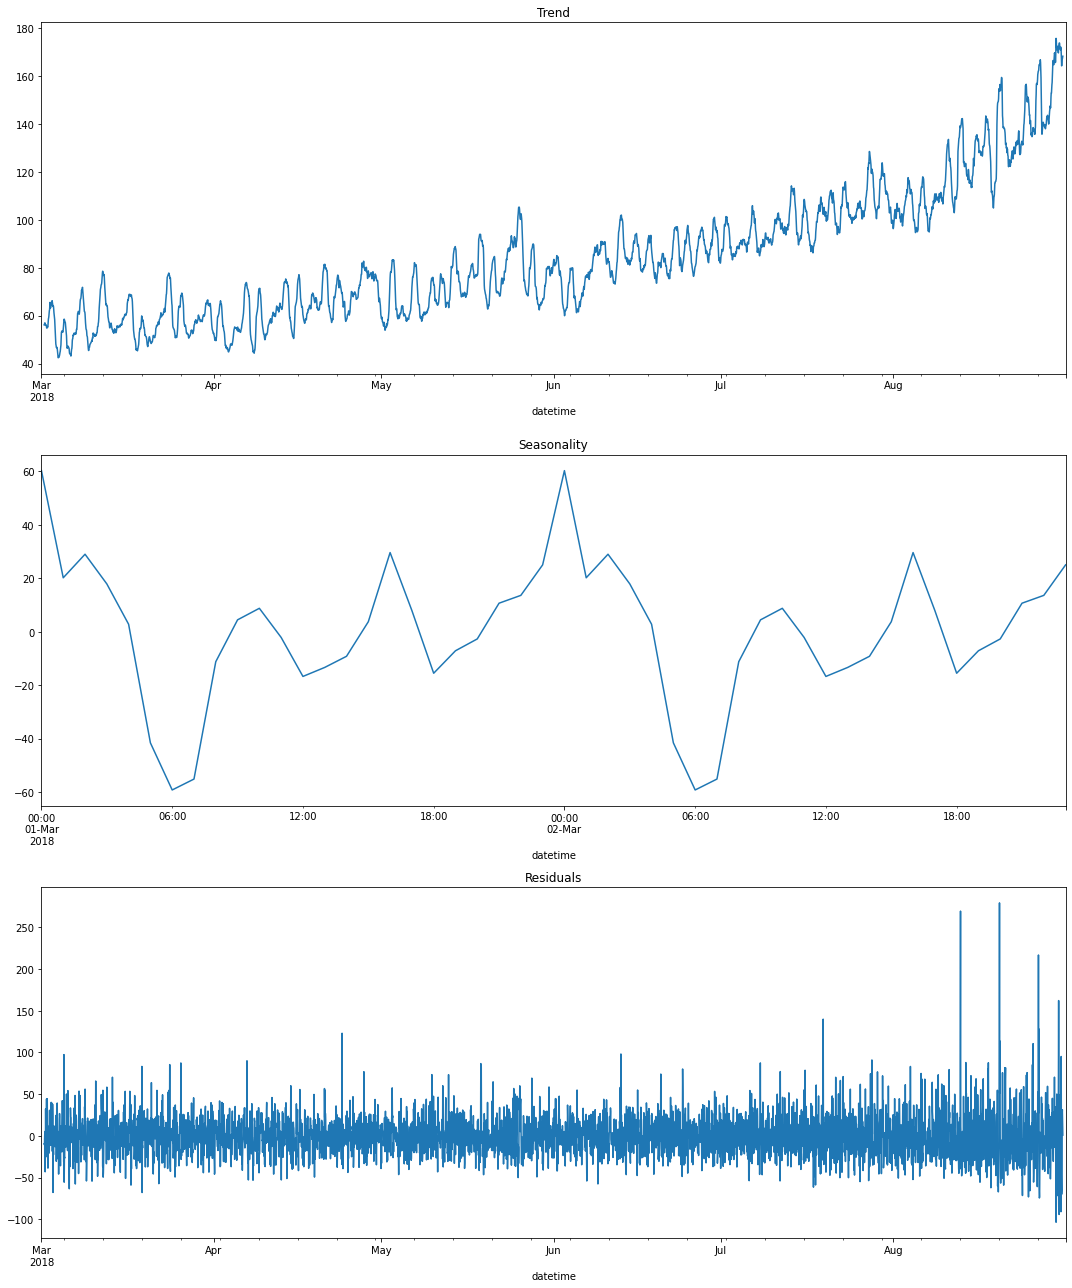

In [7]:
#Построим графики тренда, сезонности (по часам) и остатка
plt.figure(figsize=(15, 18))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01 00:00:00': '2018-03-02 23:00:00'].plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

### Вывод

Временной ряд был разложен на тренд, сезонность (по часам) и остаток. Как видно на графике сезонности, самые популярные часы - ночные и вечерние.

## Обучение

In [8]:
#Напишем функцию, которая будет создавать календарные, отстающие признаки и добавлять признак скользящего среднего
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [9]:
#Применим функцию на нашем датафрейме с ресемплингом
make_features(df_resample, 10, 10)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,173.3
2018-08-31 20:00:00,154,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,166.6
2018-08-31 21:00:00,159,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,162.9


In [10]:
#Применим TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=6)

In [27]:
#Разделим данные на тренировочную и тестовую выборки
train, test = train_test_split(df_resample, shuffle=False, test_size=0.1, random_state = 12345)
train = train.dropna()

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [28]:
#Для LinearRegression найдём лучшие параметры и обучим модель
parameters_LR = {'normalize':[True, False], 'fit_intercept':[True, False], 'copy_X': [True, False],
               'n_jobs': [-1, None, 1], 'positive': [True, False]}
model_LR = LinearRegression()
grid_LR = GridSearchCV(estimator=model_LR, param_grid=parameters_LR, scoring='neg_mean_squared_error', 
                        n_jobs=-1, cv=tscv, verbose=1)
grid_LR.fit(X_train, y_train)
expected_y_LR  = y_test
predicted_y_LR = grid_LR.predict(X_test)

Fitting 6 folds for each of 48 candidates, totalling 288 fits


In [29]:
#Для RandomForestRegressor найдём лучшие параметры и обучим модель
parameters_RFR = {'n_estimators':[10, 50, 100], 'max_depth':[15, 30, None], 'n_jobs': [-1, None, 1], 
                  'warm_start':[True, False], 'random_state':[12345]}
model_RFR = RandomForestRegressor()
grid_RFR = GridSearchCV(estimator=model_RFR, param_grid=parameters_RFR, scoring='neg_mean_squared_error', 
                        n_jobs=-1, cv=tscv, verbose=1)
grid_RFR.fit(X_train, y_train)
expected_y_RFR  = y_test
predicted_y_RFR = grid_RFR.predict(X_test)

Fitting 6 folds for each of 54 candidates, totalling 324 fits


In [30]:
#Для DecisionTreeRegressor найдём лучшие параметры и обучим модель
parameters_DTR = {'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 
                  'splitter':['best', 'random'], 'max_depth':[15, 30, None], 'random_state':[12345]}
model_DTR = DecisionTreeRegressor()
grid_DTR = GridSearchCV(estimator=model_DTR, param_grid=parameters_DTR, scoring='neg_mean_squared_error', 
                        n_jobs=-1, cv=tscv, verbose=1)
grid_DTR.fit(X_train, y_train)
expected_y_DTR  = y_test
predicted_y_DTR = grid_DTR.predict(X_test)

Fitting 6 folds for each of 24 candidates, totalling 144 fits


### Вывод

Была написана функция для создания признаков, которая применилась для нашего датафрейма, а также разделены данные на тренировочную и тестовую выборки и обучены модели LinearRegression, RandomForestRegressor, DecisionTreeRegressor.

## Тестирование

RMSE for LinearRegression: 53.39963262684578


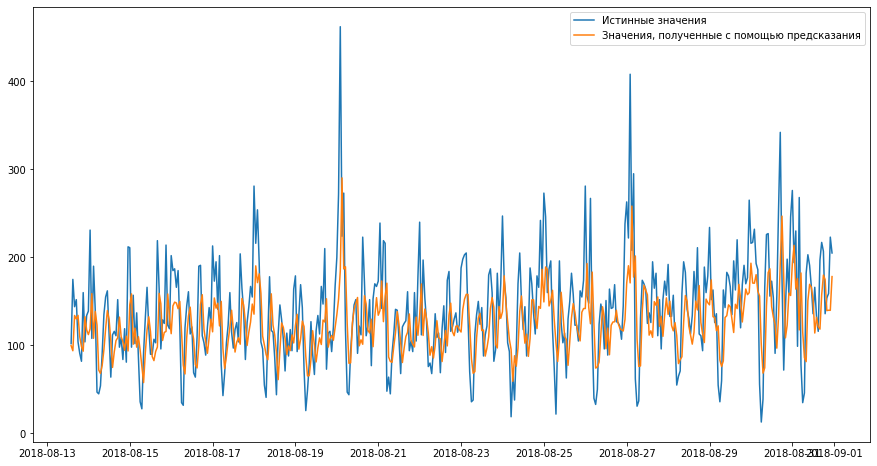

In [31]:
#Проверим качество RMSE для LinearRegression и для наглядности нанесём на график
print("RMSE for LinearRegression:", mean_squared_error(expected_y_LR, predicted_y_LR)**(.5))
plt.figure(figsize=(15, 8))
plt.plot(X_test.index, y_test, label='Истинные значения')
plt.plot(X_test.index, predicted_y_LR, label='Значения, полученные с помощью предсказания')
plt.legend()
plt.show()

RMSE for RandomForestRegressor: 45.698796008702836


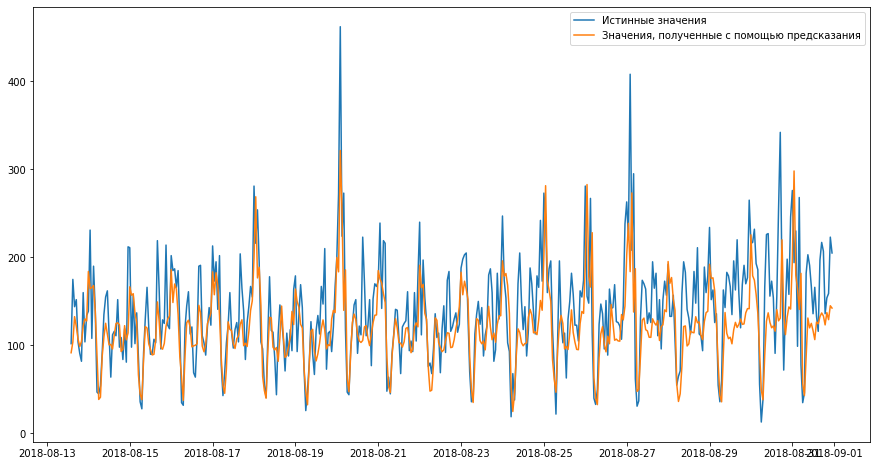

In [32]:
#Проверим качество RMSE для RandomForestRegressor и для наглядности нанесём на график
print('RMSE for RandomForestRegressor:', mean_squared_error(expected_y_RFR, predicted_y_RFR)**(.5))
plt.figure(figsize=(15, 8))
plt.plot(X_test.index, y_test, label='Истинные значения')
plt.plot(X_test.index, predicted_y_RFR, label='Значения, полученные с помощью предсказания')
plt.legend()
plt.show()

RMSE for DecisionTreeRegressor: 54.038142015918964


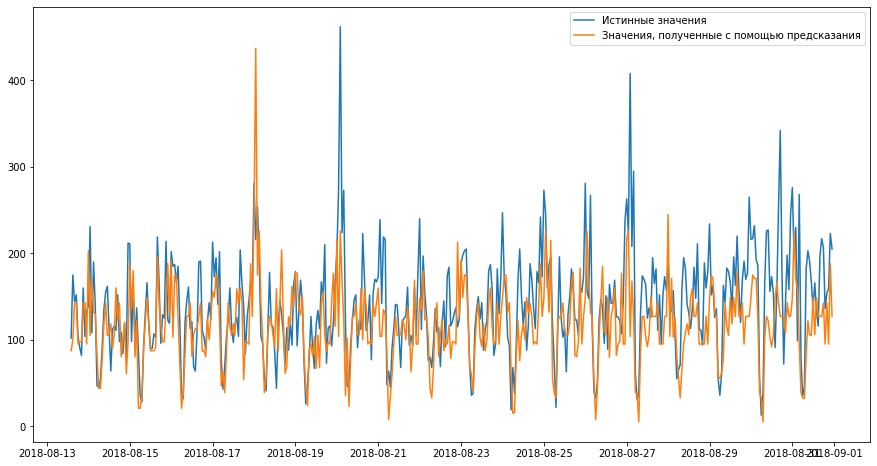

In [33]:
#Проверим качество RMSE для DecisionTreeRegressor и для наглядности нанесём на график
print('RMSE for DecisionTreeRegressor:', mean_squared_error(expected_y_DTR, predicted_y_DTR)**(.5))
plt.figure(figsize=(15, 8))
plt.plot(X_test.index, y_test, label='Истинные значения')
plt.plot(X_test.index, predicted_y_DTR, label='Значения, полученные с помощью предсказания')
plt.legend()
plt.show()

### Вывод

На тестовой выборке были получены метрики качества RMSE для 3 моделей:

RMSE for LinearRegression: 52.81883937288643

RMSE for RandomForestRegressor: 45.81912679072194

RMSE for DecisionTreeRegressor: 54.038142015918964

## Общий вывод

Таким образом, наилучшая модель - RandomForestRegressor, которая имеет значение 45.81912679072194 < 48.